### 令和6年6月26日
欠損値を埋めたデータセットの作成
ターゲットエンコーディング

#### 1. 読み込み

In [1]:
# ライブラリの読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors , KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
# LGBMClassifier
import lightgbm as lgbm
from lightgbm import LGBMClassifier
from hyperopt import hp, fmin, tpe, Trials
import warnings
import sys
sys.path.append('../')
from my_utils import MyUtils
warnings.filterwarnings('ignore')

INPUT_DIR = "../input/"
output_path = "C:/Users/gwsgs/workSpace/GCIcomp2/02.（公開）コンペ2/output/"
exel_path = 'score_record.xlsx' 
utils = MyUtils(input_path=INPUT_DIR, output_path=output_path, exel_path=exel_path)  
params = utils.params
output_path = utils.get_output_path

In [10]:
# データの読み込み
train, test, X_train, y_train, sample_sub = utils.load_data()
HAS_NAN_FEATURE = train.columns[train.isna().sum() > 0].tolist()
NUMERICAL_FEATURES = train.select_dtypes(include=[np.number]).columns.tolist()
CATEGORICAL_FEATURES = train.select_dtypes(exclude=[np.number]).columns.tolist()


['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']


#### 2. 前処理と特徴量作成

In [4]:
# 特徴量の作成
# CODE_GENDERが1かつNAME_FAMILY_STATUSがmarriedの場合 = 1,  新しく特徴量[female_marride]を作成
# OCCUPATION_TYPEのLow-skill Laborersを1、それ以外を0に変換。新しく特徴量[is_low_skill]を作成
train["is_low_skill"] = train["OCCUPATION_TYPE"].apply(lambda x: 1 if x == "Low-skill Laborers" else 0)
test["is_low_skill"] = test["OCCUPATION_TYPE"].apply(lambda x: 1 if x == "Low-skill Laborers" else 0)

# 欠損値のラベルカウントエンコーディング
missing_embeded_festure = ['FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_TYPE_SUITE','OCCUPATION_TYPE','OCCUPATION_TYPE']
train, test = utils.label_count(train, test, missing_embeded_festure)
to_numerical = ['NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','ORGANIZATION_TYPE']
train, test = utils.label_count(train, test, to_numerical)
# 外れ値の除去
train, data
# 欠損値のターゲットエンコーディング
missing_embeded_festure = train.columns[train.isna().sum() > 0]
train, test = utils.target_encoding(train, test, missing_embeded_festure)


TypeError: 'numpy.float64' object is not callable

In [13]:
train[missing_embeded_festure].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171202 entries, 0 to 171201
Data columns (total 16 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   AMT_ANNUITY                 171196 non-null  float64
 1   AMT_GOODS_PRICE             171039 non-null  float64
 2   OWN_CAR_AGE                 58210 non-null   float64
 3   CNT_FAM_MEMBERS             171200 non-null  float64
 4   EXT_SOURCE_1                52274 non-null   float64
 5   EXT_SOURCE_2                170833 non-null  float64
 6   EXT_SOURCE_3                116616 non-null  float64
 7   OBS_30_CNT_SOCIAL_CIRCLE    170642 non-null  float64
 8   DEF_30_CNT_SOCIAL_CIRCLE    170642 non-null  float64
 9   OBS_60_CNT_SOCIAL_CIRCLE    170642 non-null  float64
 10  DEF_60_CNT_SOCIAL_CIRCLE    170642 non-null  float64
 11  DAYS_LAST_PHONE_CHANGE      171201 non-null  float64
 12  AMT_REQ_CREDIT_BUREAU_HOUR  148086 non-null  float64
 13  AMT_REQ_CREDIT

In [4]:
# 欠損値の補完を行う
train["CNT_FAM_MEMBERS"].fillna(train["CNT_FAM_MEMBERS"].median(), inplace=True)
test["CNT_FAM_MEMBERS"].fillna(train["CNT_FAM_MEMBERS"].median(), inplace=True)

In [5]:
# # 特徴量の修正
# # DAYS_EMPLOYEDの365243という値をnanに変更
# train["DAYS_EMPLOYED"]  = train["DAYS_EMPLOYED"].replace(365243, np.nan)

In [6]:
# カテゴリカルデータを数値に変換
# NAME_CONTRACT_TYPEのラベルエンコーディング
train["NAME_CONTRACT_TYPE"] = train["NAME_CONTRACT_TYPE"].map({"Cash loans": 0, "Revolving loans": 1})
test["NAME_CONTRACT_TYPE"] = test["NAME_CONTRACT_TYPE"].map({"Cash loans": 0, "Revolving loans": 1})
# CODE_GENDERのラベルエンコーディング(男性=0, 女性=1, XNA=0)
train["CODE_GENDER"] = train["CODE_GENDER"].map({"M": 0, "F": 1, "XNA": 0})
test["CODE_GENDER"] = test["CODE_GENDER"].map({"M": 0, "F": 1, "XNA": 0})

In [6]:
# 特徴量の作成
# DAYS_LAST_PHONE_CHANGEを年に変換
train["YEARS_PHONR_CHANGE"] = train["DAYS_LAST_PHONE_CHANGE"] / -365
test["YEARS_PHONR_CHANGE"] = test["DAYS_LAST_PHONE_CHANGE"] / -365
# DAYS_EMPLOYEDを年に変換
train["YEARS_EMPLOYED"] = train["DAYS_EMPLOYED"] / 365
test["YEARS_EMPLOYED"] = test["DAYS_EMPLOYED"] / 365
# DAYS_REGISTRATIONを年に変換
train["YEARS_REGISTRATION"] = train["DAYS_REGISTRATION"] / -365
test["YEARS_REGISTRATION"] = test["DAYS_REGISTRATION"] / -365
# DAYS_ID_PUBLISHを年に変換
train["YEARS_ID_PUBLISH"] = train["DAYS_ID_PUBLISH"] / -365
test["YEARS_ID_PUBLISH"] = test["DAYS_ID_PUBLISH"] / -365
#  1 if AMT_GOODS_PRICEnan==nan other = 0
train["AMT_GOODS_PRICE_ISNAN"] = train["AMT_GOODS_PRICE"].isnull().astype(int)
test["AMT_GOODS_PRICE_ISNAN"] = test["AMT_GOODS_PRICE"].isnull().astype(int)
# own car and realty = 4 , own realty = 2 , own car = 1 , other = 0 commentと異なる
train["OWN_CAR_REALTY"] = train["FLAG_OWN_CAR"] + train["FLAG_OWN_REALTY"]
test["OWN_CAR_REALTY"] = test["FLAG_OWN_CAR"] + test["FLAG_OWN_REALTY"]
# DAYS_EMPLOYEDが0以上の場合、1 それ以外は0
train["not_employed"] = train["DAYS_EMPLOYED"].apply(lambda x: 1 if x > 0 else 0)




# 参考 https://www.kaggle.com/competitions/home-credit-default-risk/discussion/64821
# AMT_CREDITとAMT_ANNUITYの比率
train["CREDIT_TO_ANNUITY_RATIO"] = train["AMT_CREDIT"] / train["AMT_ANNUITY"]
test["CREDIT_TO_ANNUITY_RATIO"] = test["AMT_CREDIT"] / test["AMT_ANNUITY"]
# AMT_CREDITとAMT_GOODS_PRICEの比率
train["CREDIT_TO_GOODS_RATIO"] = train["AMT_CREDIT"] / train["AMT_GOODS_PRICE"]
test["CREDIT_TO_GOODS_RATIO"] = test["AMT_CREDIT"] / test["AMT_GOODS_PRICE"]
# AMT_CREDITとAMT_ANNUITYの比率
train["AMT_CREDIT_TO_AMT_ANNUITY"] = train["AMT_CREDIT"] / train["AMT_ANNUITY"]
test["AMT_CREDIT_TO_AMT_ANNUITY"] = test["AMT_CREDIT"] / test["AMT_ANNUITY"]
# DAYS_BIRTH/ -365
train["YEARS_BIRTH"] = train["DAYS_BIRTH"] / -365
test["YEARS_BIRTH"] = test["DAYS_BIRTH"] / -365

In [8]:
days_feature = ["DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_REGISTRATION", "DAYS_ID_PUBLISH"]
# # 年単位でビニング
# train = utils.from_days_to_year_bin(train, days_feature)
# test = utils.from_days_to_year_bin(test, days_feature)
# 月単位でビニング
train = utils.from_days_to_month_bin(train, days_feature)
test = utils.from_days_to_month_bin(test, days_feature)
# 週単位でビニング
train = utils.from_days_to_week_bin(train, days_feature)
test = utils.from_days_to_week_bin(test, days_feature)


In [9]:
X_train, X_valid, y_train, y_valid, X_test, X, y = utils.split_data(train, test)

### 3. 観察

In [34]:
print(f"X_train:{X_train.shape}")
print(f"X_valid:{X_valid.shape}")
print(f"X_test:{X_test.shape}")
print(f"X:{X.shape}")
print(f"y_train:{y_train.shape}")
print(f"y_valid:{y_valid.shape}")
print(f"y:{y.shape}")

X_train:(119841, 69)
X_valid:(51361, 69)
X_test:(61500, 69)
X:(171202, 69)
y_train:(119841,)
y_valid:(51361,)
y:(171202,)


In [13]:
# import sweetviz as sv

# # Sweetvizの分析レポートを作成（学習データとテストデータの比較、目的変数を指定）
# report = sv.compare([train, "Train Data"], [test, "Test Data"], target_feat='TARGET')

# # レポートをHTMLファイルとして保存
# report.show_html(open_browser=True)

                                             |          | [  0%]   00:00 -> (? left)

<Axes: xlabel='EXT_SOURCE_1', ylabel='DAYS_BIRTH_bin_week'>

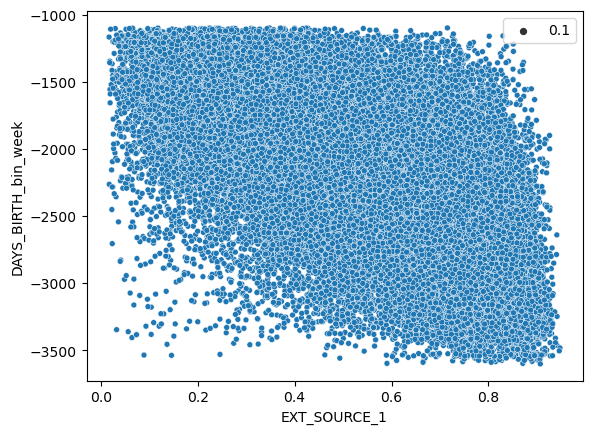

In [23]:
sns.scatterplot(data=train, x='EXT_SOURCE_1',y='DAYS_BIRTH_bin_week', size=0.1)

## 4. 予測

In [10]:
# 複数のモデルを使って予測値を出力
utils.multi_model_predict(X_train, y_train, X_valid, y_valid, hasNan=False)

LogisticRegression()_start


ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [11]:
# 複数のモデルでとりあえず予測
utils.multi_model_predict(X_train, y_train, X_valid, y_valid, hasNan=True)

GradientBoostingClassifier()_start


ValueError: Input X contains NaN.
GradientBoostingClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [14]:
def objective(args):
    lgb = LGBMClassifier(
        num_leaves = args['num_leaves'],
        max_depth = args['max_depth'],
        n_estimators = args['n_estimators'],
        learning_rate = args['learning_rate'],
        # min_child_samples = args['min_child_samples'],
        reg_lambda = args['reg_lamb'],
        bagging_freq = args['bagging_freq'],
        bagging_fraction = args['bagging_fraction'],
        feature_fraction = args['feature_fraction'],
        min_data_in_leaf = args['min_data_in_leaf'],
        random_state = params['random_state'],
        objective = params['objective'],
        metric = params['metric'],
        verbosity = params['verbosity'],
        boosting_type = params['boosting_type'],
        early_stopping_round = 50
        )
    lgb.fit(X_train, y_train,
            eval_set = [(X_valid, y_valid)]
        )
    lgb_valid_pred = lgb.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid, lgb_valid_pred)
    return -1.0 * auc   

In [17]:
import datetime
n_iter = 50
trials = Trials()
time = datetime.datetime.now().strftime('%Y%m%d%H%M')
best = fmin(
    objective,
    space = params,
    algo=tpe.suggest,
    max_evals=n_iter,
    trials=trials,
    verbose=-1, # 試行の過程を出力
    early_stop_fn=None,
    show_progressbar = True,
    # trials_save_file=f"{output_path}_trials_save_file_{time}.pkl"
)

100%|██████████| 50/50 [03:43<00:00,  4.48s/trial, best loss: -0.7612881902070765]


In [27]:
lgb = LGBMClassifier(
        learning_rate = best['learning_rate'],
        objective = params['objective'],
        max_depth = best['max_depth'],
        # min_child_samples = best['min_child_samples'],
        n_estimators = best['n_estimators'],
        num_leaves = best['num_leaves'],
        reg_lambda= best['reg_lamb'],
        bagging_freq = best['bagging_freq'],
        bagging_fraction = best['bagging_fraction'],
        feature_fraction = best['feature_fraction'],
        min_data_in_leaf = best['min_data_in_leaf'],
        verbose = -1,
        random_state = 0,)
lgb.fit(X_train, y_train)

lgb_train_pred = lgb.predict_proba(X_train)[:, 1]
lgb_valid_pred = lgb.predict_proba(X_valid)[:, 1]
print(best)
print(f"Train Score: {roc_auc_score(y_train, lgb_train_pred)}")
print(f"Valid Score: {roc_auc_score(y_valid, lgb_valid_pred)}")

{'bagging_fraction': 0.7839909499664472, 'bagging_freq': 5, 'feature_fraction': 0.8109424066113267, 'learning_rate': 0.08354735680174623, 'max_depth': 2, 'min_data_in_leaf': 81, 'n_estimators': 937, 'num_leaves': 71, 'reg_lamb': 7.967732592111622}
Train Score: 0.7859991450064949
Valid Score: 0.7611888100635191


In [19]:
utils.save_score_to_exel(utils.exel_path, best, trials.best_trial['result']['loss'] * -1, time)

In [ ]:
dic = {}
for i,  column in enumerate(test.columns):
    dic[i] = column
dic

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

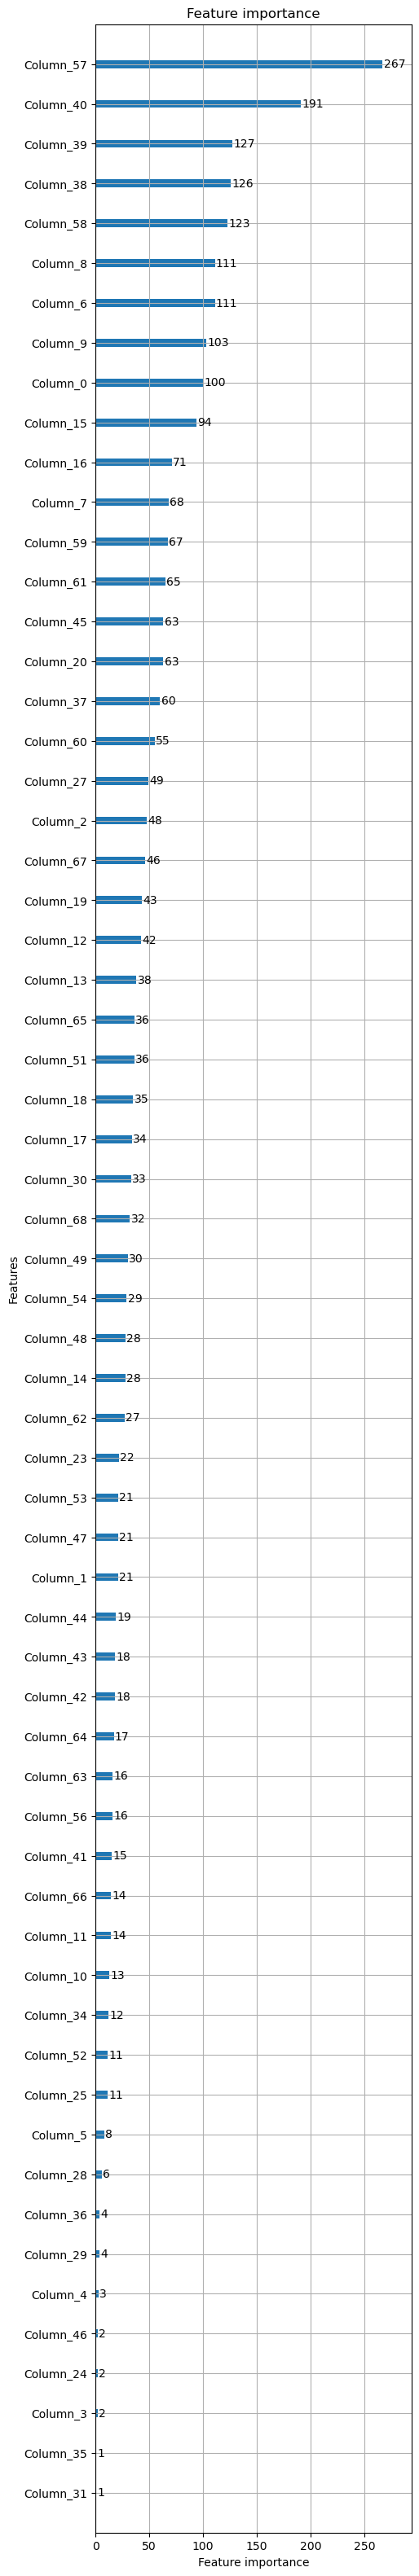

In [28]:
lgbm.plot_importance(lgb,figsize=(5, 40))

In [22]:
lgbm.plot_metric(lgb)

ValueError: eval results cannot be empty.

#### 4. 予測結果の作成
最後にテストデータに対して予測を行い、提出用のcsvファイルを作成します。

In [23]:
# テストデータに対する予測値の作成
# pred = lgb.predict_proba(X_test, num_iteration=lgb.best_iteration)[:, 1]
pred = lgb.predict_proba(X_test)[:, 1]

In [24]:
# 予測結果を提出用のフォーマットに格納
sample_sub['TARGET'] = pred
sample_sub

AttributeError: 'MyUtils' object has no attribute 'sample_sub'

In [ ]:
# 提出用のcsvファイルを作成
# formatを指定して現在時刻を取得（yyyyMMddhhmm）

sample_sub.to_csv(f'{output_path}/{time}.csv',index=False)

以上で、Home Credit Default Riskコンペのチュートリアルは終了です。今回は、50種類ある特徴量のうち5種類しか使用していないので、まだまだ改善の余地があります。この後は、このnotebookやこれまでの教材を参考にして、さらなるスコアの向上を目指してください！